# Bayesian Interrupted Time Series

Interrupted Time Series (ITS) analysis is a powerful approach for estimating the causal impact of an intervention or treatment when you have a single time series of observations. The key idea is to compare what actually happened after the intervention to what would have happened in the absence of the intervention (the "counterfactual"). To do this, we train a statistical model on the pre-intervention data (when no treatment has occurred) and then use this model to forecast the expected outcomes into the post-intervention period as-if treatment had not occurred. The difference between the observed outcomes and these model-based counterfactual predictions provides an estimate of the causal effect of the intervention, along with a measure of uncertainty if using a Bayesian approach.

## What do we mean by _causal impact_ in Interrupted Time Series?

In the context of interrupted time series analysis, the term **causal impact** refers to the estimated effect of an intervention or event on an outcome of interest. We can break this down into two components which tell us different aspects of the intervention's effect:

- The **Instantaneous Bayesian Causal Effect** at each time point is the difference between the observed outcome and the model's posterior predictive distribution for the counterfactual (i.e., what would have happened without the intervention). This is not just a single number, but a full probability distribution that reflects our uncertainty.
- The **Cumulative Bayesian Causal Impact** is the sum of these instantaneous effects over the post-intervention period, again represented as a distribution.

Let $y_t$ be the observed outcome at time $t$ (after the intervention), and $\tilde{y}_t$ be the model's counterfactual prediction for the same time point. Then:
- **Instantaneous effect:** $\Delta_t = y_t - \tilde{y}_t$
- **Cumulative effect (up to time $T$):** $C_T = \sum_{t=1}^T \Delta_t$

In Bayesian analysis, both $\tilde{y}_t$ and $\Delta_t$ are distributions, not just point estimates.

### Why does this matter for decision making?
These metrics allow you to answer questions like:
- "How much did the intervention change the outcome, compared to what would have happened otherwise?"
- "What is the total effect of the intervention over time, and how certain are we about it?"

By providing both instantaneous and cumulative effects, along with their uncertainty, you can make more informed business decisions and better understand the impact of your interventions.

## Interrupted Time Series example

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

Load data

In [3]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


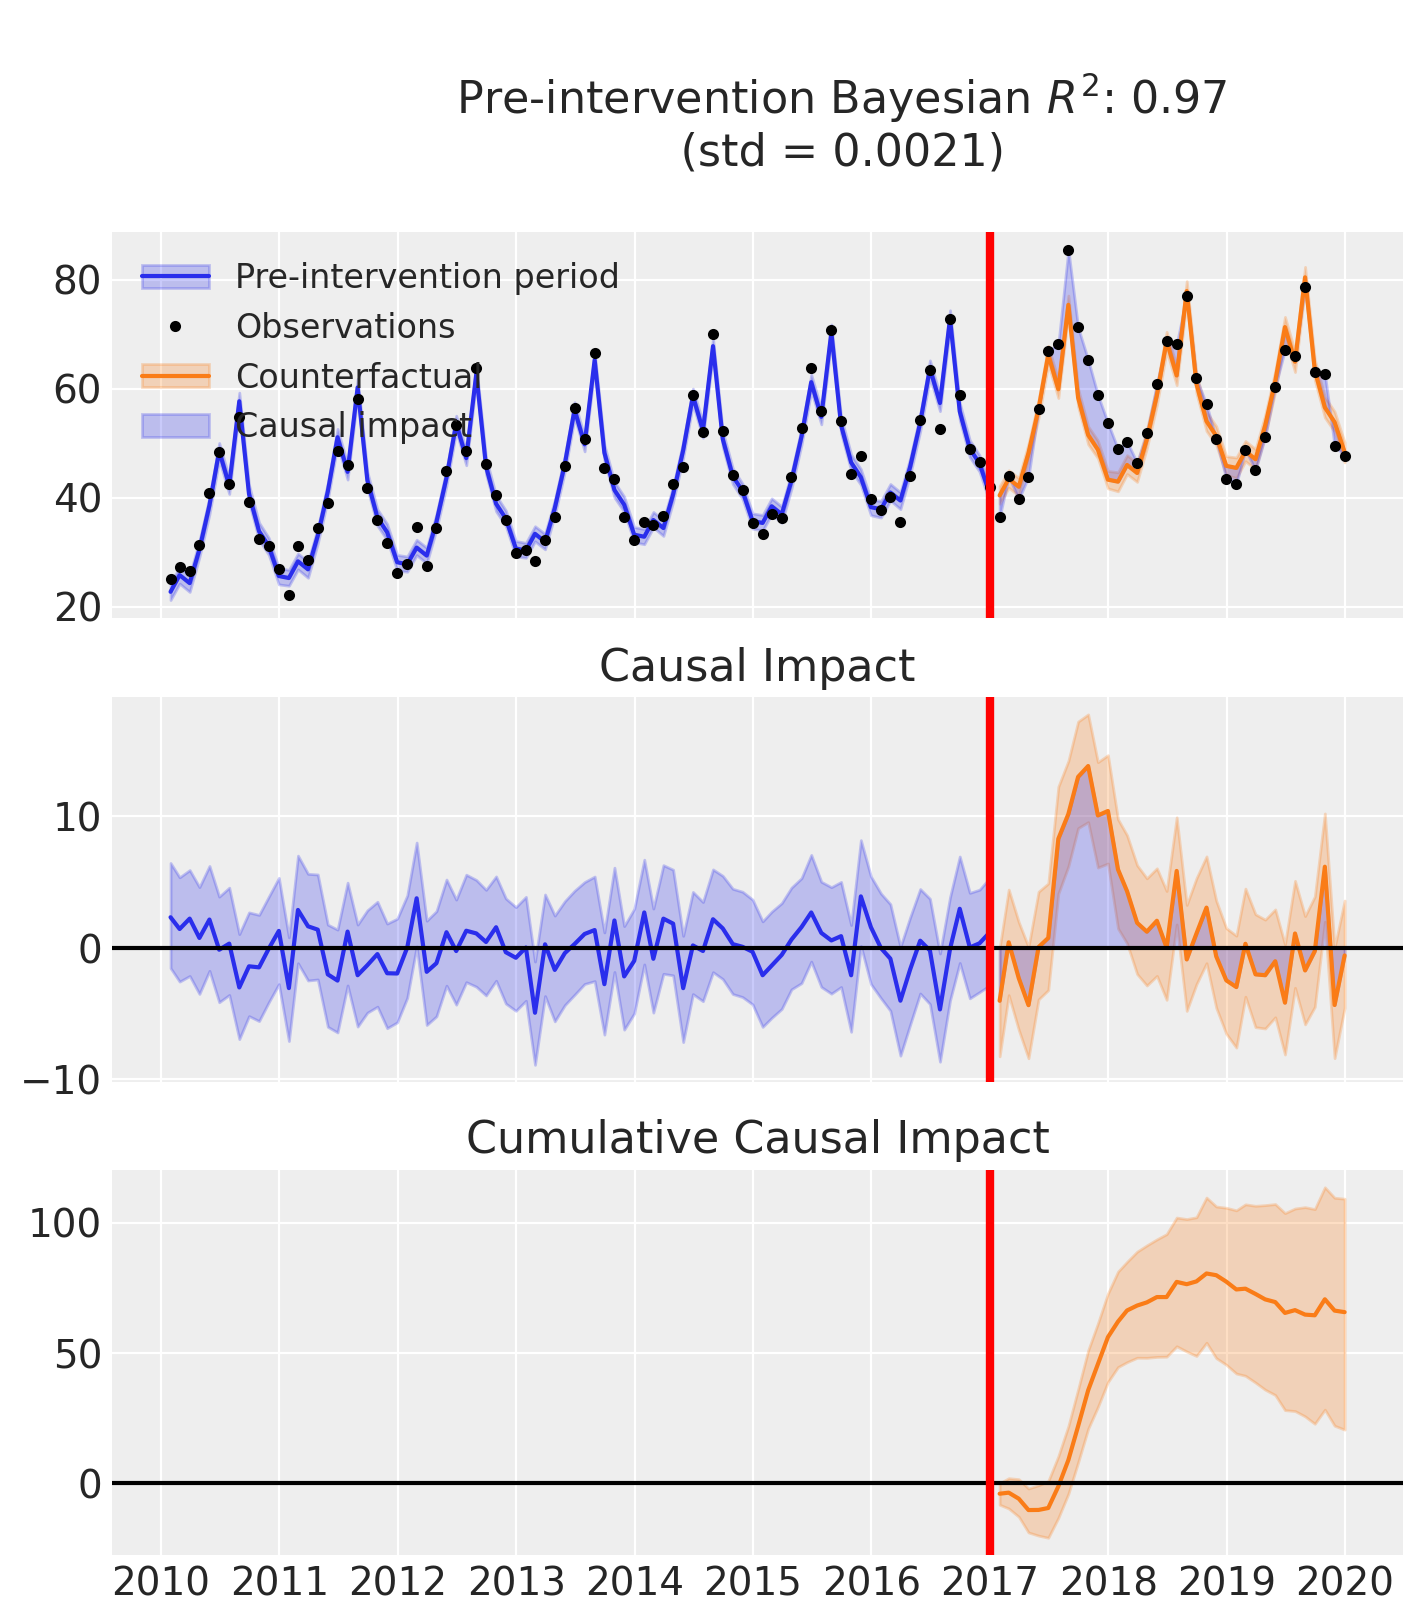

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       23, 94% HDI [21, 24]
    C(month)[T.2]   2.9, 94% HDI [0.95, 4.8]
    C(month)[T.3]   1.2, 94% HDI [-0.82, 3.1]
    C(month)[T.4]   7.1, 94% HDI [5.2, 9.2]
    C(month)[T.5]   15, 94% HDI [13, 17]
    C(month)[T.6]   25, 94% HDI [23, 27]
    C(month)[T.7]   18, 94% HDI [16, 20]
    C(month)[T.8]   33, 94% HDI [31, 36]
    C(month)[T.9]   16, 94% HDI [14, 18]
    C(month)[T.10]  9.2, 94% HDI [7.3, 11]
    C(month)[T.11]  6.3, 94% HDI [4.4, 8.2]
    C(month)[T.12]  0.58, 94% HDI [-1.3, 2.6]
    t               0.21, 94% HDI [0.19, 0.23]
    sigma           2, 94% HDI [1.7, 2.3]


As well as the model coefficients, we might be interested in the estimated causal impact of the intervention. The post intervention causal impact estimates are contained in the `post_impact` attribute, which is of type `xarray.DataArray`. We can take a look at what this looks like, and we can see that it consists of 3 dimensions: `chain`, `draw`, and time (`obs_ind`). The `chain` and `draw` dimensions are used to store the samples from the posterior distribution, while the `obs_ind` dimension corresponds to the time points in the time series.

In [7]:
result.post_impact

<xarray.DataArray (treated_units: 1, chain: 4, draw: 1000, obs_ind: 36)> Size: 1MB
array([[[[-4.40763186e+00, -2.21379303e+00, -2.18183638e+00, ...,
           5.20971399e+00, -4.78176382e+00, -2.90301452e+00],
         [-5.94372215e+00, -1.12711102e+00, -5.47111586e+00, ...,
           5.06176401e+00, -4.49704055e+00,  6.95769258e-01],
         [-8.04798147e-01,  1.24057812e+00,  5.45700873e-01, ...,
           9.29875204e+00, -7.15645587e+00, -3.77103015e+00],
         ...,
         [-5.25712112e+00, -3.15528398e-01, -4.02137936e+00, ...,
           4.16007293e+00, -2.69921587e+00,  3.84486567e-03],
         [-3.07903317e-01,  2.19361971e-02, -5.32527964e+00, ...,
           9.16604880e+00, -4.41150637e+00, -1.30639701e+00],
         [-7.15868198e+00, -2.92393383e+00, -5.75443740e+00, ...,
           3.45201848e+00, -2.79596476e+00, -5.60220629e-01]],

        [[-3.12949291e+00,  9.77587182e-01, -2.34613672e+00, ...,
           5.17049758e+00, -7.30312766e+00, -4.47417044e+00],
         [-8.61533822e-01, -1.67375152e+00, -1.96463130e+00, ...,
           4.20238236e+00, -3.15001390e+00,  7.67670071e-01],
         [-3.25290947e+00, -6.83348216e-01, -3.96840321e+00, ...,
           4.12328620e+00, -7.20005863e+00,  4.19162575e+00],
...
           7.64452849e+00, -2.96514932e+00, -2.66864823e+00],
         [-4.06898662e+00, -3.56521547e-01, -4.00697003e+00, ...,
           6.74151894e+00, -6.02181592e+00,  2.18499676e+00],
         [-2.06081549e+00, -3.65820243e+00, -1.85920043e-01, ...,
           7.68138498e+00, -4.38117002e+00,  2.69937339e-01]],

        [[-2.18931891e+00,  3.01008947e+00, -1.27849259e+00, ...,
           7.08232220e+00, -4.26815409e+00, -1.04451248e+00],
         [-3.95470234e+00,  5.36324094e+00, -2.54766101e+00, ...,
           6.49555606e+00, -3.44084989e+00, -2.52054268e-01],
         [-3.90158741e+00, -2.76374570e+00, -1.18083461e-01, ...,
           6.66749598e+00,  2.07478260e-01,  4.03526749e-01],
         ...,
         [-6.69792991e+00,  9.50374906e-01, -3.95089423e+00, ...,
           8.63754836e+00, -6.28606486e+00,  1.09685685e+00],
         [-3.40735490e+00,  2.32405447e-01, -6.02351344e+00, ...,
           7.25937210e+00, -8.20840647e+00, -1.81566073e+00],
         [-4.71010333e+00,  1.77921987e-02,  4.05677467e-01, ...,
           4.91210037e+00, -7.23324739e+00, -1.99889391e+00]]]],
      shape=(1, 4, 1000, 36))
Coordinates:
  * obs_ind        (obs_ind) datetime64[ns] 288B 2017-01-31 ... 2019-12-31
  * treated_units  (treated_units) <U6 24B 'unit_0'
  * chain          (chain) int64 32B 0 1 2 3
  * draw           (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999

We have already seen a visual representation of this - the middle plot (see above) generated when calling the `plot` method. But often we would like to reduce this down to a simpler estimate. We can do this by various aggregation methods.

If we wanted to evaluate the total causal impact of the intervention over the whole post-intervention period, we can use the `sum` method. This will sum the post-intervention impact estimates across all time points in the post-intervention period.

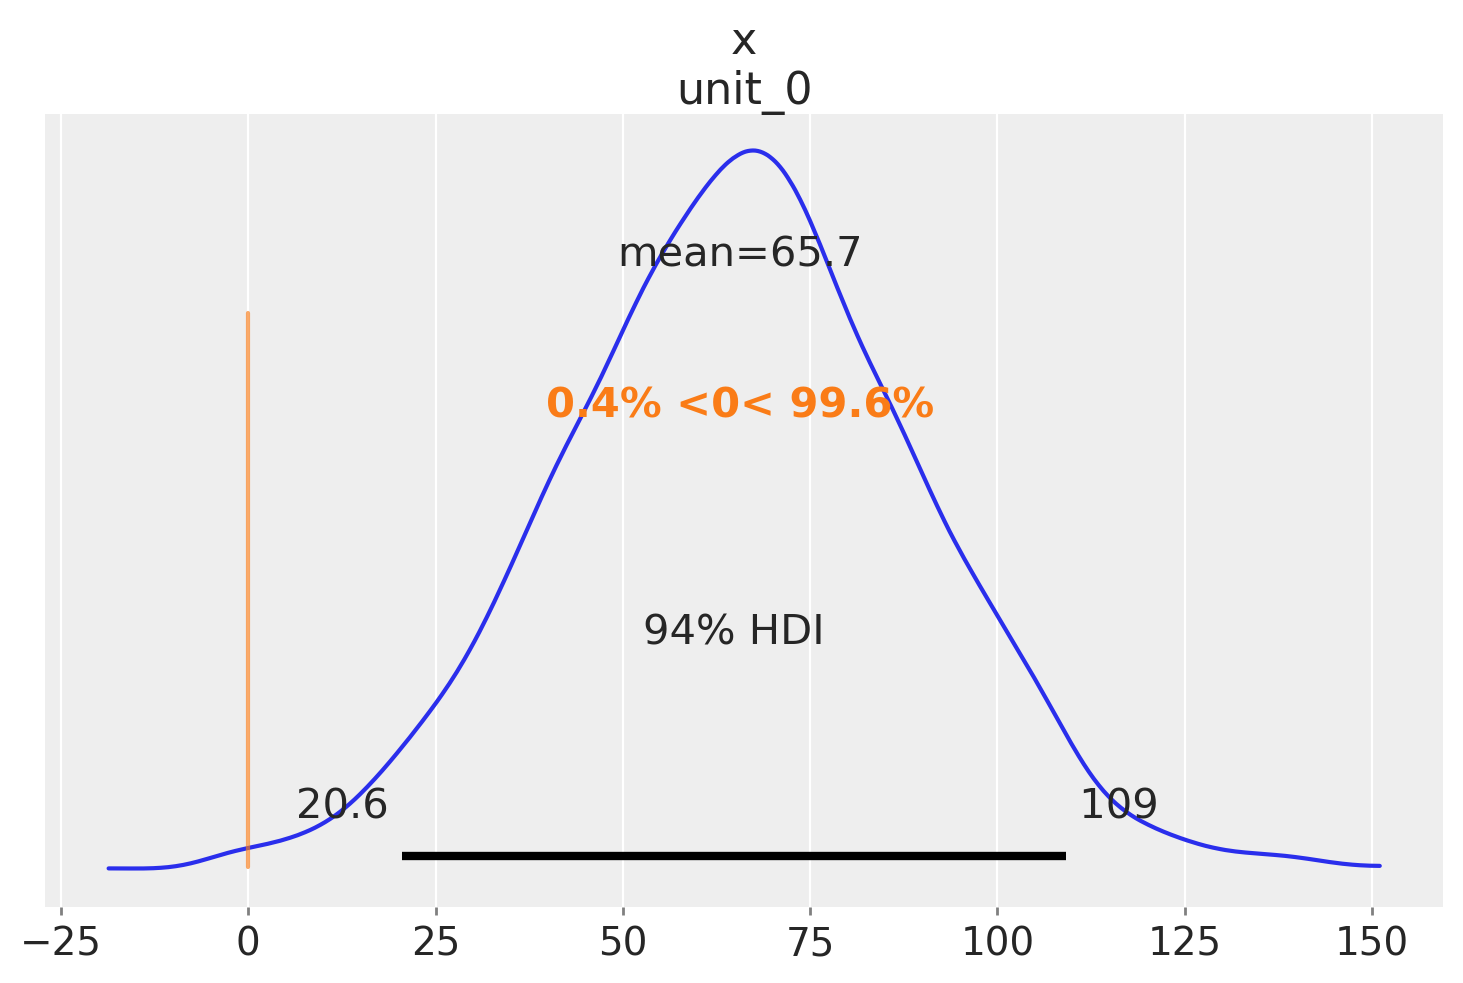

In [8]:
az.plot_posterior(
    result.post_impact.sum("obs_ind"), ref_val=0, hdi_prob=0.94, round_to=3
);

So we could say that the most credible total causal impact of the intervention is around 66, with a 94% credible interval of around 20 to 110.

And if we want precise numerical and summary statistics of that, we can use the `arviz.summary` function:

In [9]:
az.summary(result.post_impact.sum("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[unit_0],65.654,23.943,20.56,109.182,0.461,0.354,2698.0,2479.0,1.0


Of course, if we wanted to query the estimated impact over a specific time period, we can leverage the fact that this is an `xarray.DataArray` and we can use the sel method to select the time points we are interested in. We will leave this as an exercise for the reader.

Moving on, it would also be possible to look at the mean post-intervention impact estimates, which would give us the average impact of the intervention over the post-intervention period. This can be done using the `mean` method:

In [10]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[unit_0],1.824,0.665,0.571,3.033,0.013,0.01,2698.0,2479.0,1.0


:::{warning}
Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient (like in the example here), then clearly there will be a lot of post-intervention period where the impact of the intervention has ‘worn off’. If so, then it will be hard to interpret the mean impacts real meaning.

But if there was a roughly constant impact of the intervention over the post-intervention period, then the mean causal impact can be interpreted as the mean impact of the intervention (per time point) over the post-intervention period.
:::

Similarly, if we wanted, we would also be able to query the estimated cumulative impact of the intervention over the post-intervention period by instead looking at the `post_impact_cumulative` attribute, rather than the `post_impact` attribute.